In [21]:
def make_data(raw,window,bias,states):

    
    time_samples=len(raw['Fz'][0][0])
    
    list_of_states=[]
    train_data_list=[]
    
    for c in np.arange(0,(time_samples-(window-bias)),bias):

            sum_of_states=sum(states[c:c+window])
            
            if (sum_of_states%window)==0 and (sum_of_states/window)==states[c]:

                list_of_states.append(states[c])

                train_data_list.append(np.arange(c,(c+window)))



    return list_of_states, train_data_list



def conf_plot(labels_test,y_pred,states):
    import seaborn
    
    cm=confusion_matrix( labels_test,y_pred)
    df_cm = pd.DataFrame(cm, index = [i for i in states],
                      columns = [i for i in states])
    plt.figure(figsize = (10,8))
    ax = sns.heatmap(df_cm, annot=True, fmt="d")
    ax.set_ylim(len(states)+0.5, -0.5)
    
    
def acc_per_class(y_true,y_pred,states):
    cm = confusion_matrix(y_true, y_pred)
    #array([[1, 0, 0],
    #   [1, 0, 0],
    #   [0, 1, 2]])

    #Now the normalize the diagonal entries
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #array([[1.        , 0.        , 0.        ],
    #      [1.        , 0.        , 0.        ],
    #      [0.        , 0.33333333, 0.66666667]])

    #The diagonal entries are the accuracies of each class
    
    for i in range(len(states)):
        print(states[i]+'   '+str(cm.diagonal()[i]))
        
    return #cm.diagonal()
    
        
    

from sklearn.metrics import accuracy_score
from sklearn.model_selection import ShuffleSplit, cross_val_score

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import  mne 
from mne import Epochs, pick_types, events_from_annotations
from mne.io import concatenate_raws
from mne.io.edf import read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

# pyriemann import
from pyriemann.classification import MDM , TSclassifier
from pyriemann.estimation import Covariances,Shrinkage


# sklearn imports
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [6]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from sklearn.model_selection import GridSearchCV

In [3]:
import pandas as pd

## Обычный риман 10 испытуемых

In [50]:

for i in range(1,5):


    subject = i
    

    tmin, tmax = -1., 7.
    event_id = dict(hands=2, feet=3)
    runs = [6, 10, 14]  # motor imagery: hands vs feet

    raw_fnames = eegbci.load_data(subject, runs)
    raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
    raw.rename_channels(lambda x: x.strip('.'))
    raw.rename_channels(lambda x: x.replace('Cp','CP'))
    raw.rename_channels(lambda x: x.replace('Fc','FC'))
    raw.rename_channels(lambda x: x.replace('Af','AF'))
    raw.rename_channels(lambda x: x.replace('Ft','FT'))
    raw.rename_channels(lambda x: x.replace('Tp','TP'))
    raw.rename_channels(lambda x: x.replace('Po','PO'))
    montage = make_standard_montage('standard_1005')
    raw.set_montage(montage)
    raw.rename_channels(lambda x: x.strip('.'))
    raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')



    events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

    picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')

    epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=None, preload=True)



    labels = epochs.events[:, -1] - 2



    cv = ShuffleSplit(10, test_size=0.2, random_state=42)

    cv = KFold(n_splits=10, random_state=42)
    epochs_data_train = 1e6 * epochs.get_data()

    cov_data_train = Covariances().transform(epochs_data_train)
    cov_data_train= Shrinkage().transform(cov_data_train)
    cov_data_train.shape


    epochs_train_tmin=1
    epochs_train_tmax=5
    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    epochs_data_train = 1e6 *epochs_train.get_data()
    epochs_data = 1e6 *epochs.get_data()


    window=1
    step=0.2

    sfreq = raw.info['sfreq']
    w_length = int(sfreq * window)   # running classifier: window length
    w_step = int(sfreq * 0.2)  # running classifier: window step size
    w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

    scores_windows = []

    w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

    cv = ShuffleSplit(10, test_size=0.2, random_state=42)
    cv_split = cv.split(epochs_data_train)


    for train_idx, test_idx in cv_split:
        y_train, y_test = labels[train_idx], labels[test_idx]



        cov_data_train = Covariances().transform(epochs_data_train[train_idx])
        cov_data_train= Shrinkage().transform(cov_data_train)

        x_train=cov_data_train

        mdm = MDM(metric=dict(mean='riemann', distance='riemann'))
        # fit classifier
        mdm.fit(x_train,y_train)

        # running classifier: test classifier on sliding window
        score_this_window = []

        for k in range(len(w_start)):
            n=w_start[k]

            cov_data_test = Covariances().transform(epochs_data[test_idx][:, :, n:(n + w_length)])
            cov_data_test= Shrinkage().transform(cov_data_test)
            y_pred=mdm.predict(cov_data_test)
            aaaa=accuracy_score(y_pred,y_test)

            score_this_window.append(aaaa)

            #one_row=[w_times[k],window,step,'MI_Hands', str(epochs_train_tmin)+' '+str(epochs_train_tmax),lda.score(X_test, y_test)]
            #ind=len(df)
            #df.loc[ind]=one_row

            #print(aaaa)

        scores_windows.append(score_this_window)

    # Plot scores over time
    w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin
    
    np.save('Riemann_results/Riemann_results'+str(i), np.array(scores_windows))



Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Ha

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Ha

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Ha

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Ha

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [38]:

def make_data(raw,window,bias,states,Fs=160):

    try:
    
        time_samples=len(raw['Fz'][0][0])
    
    except :
        
        time_samples=len(np.arange(0,raw.shape[1]*1/160,1/160))
        
        
    list_of_states=[]
    train_data_list=[]

    for c in np.arange(0,(time_samples-(window-bias)),bias):

            sum_of_states=sum(states[c:c+window])

            if (sum_of_states%window)==0 and (sum_of_states/window)==states[c]:

                list_of_states.append(states[c])

                train_data_list.append(np.arange(c,(c+window)))


    return list_of_states, train_data_list


In [25]:
import pandas as pd

In [28]:
df=pd.DataFrame(columns=['time','window','bias','tasks','csp_len','subject','validation_i','acc'])
windows=[2]
bias=[0.05]
tasks=[ 
    
    [3, 7, 11], #Motor execution: left vs right hand
    [4, 8, 12], #Motor imagery: left vs right hand
    [5, 9, 13], #Motor execution: hands vs feet
    [6, 10, 14], #Motor imagery: hands vs feet

]

tain_ranges=[
    
    [0,4]

]



for tr in tain_ranges:

    for t in tasks:

        for w in windows:

            for b in bias:

                for i in [1]:#range(19,30):


                    subject = i

                    tmin, tmax = 0., 8.
                    
                    event_id = dict(hands=2, feet=3)

                    runs = t


                    raw_fnames = eegbci.load_data(subject, runs)
                    raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
                    raw.rename_channels(lambda x: x.strip('.'))
                    raw.rename_channels(lambda x: x.replace('Cp','CP'))
                    raw.rename_channels(lambda x: x.replace('Fc','FC'))
                    raw.rename_channels(lambda x: x.replace('Af','AF'))
                    raw.rename_channels(lambda x: x.replace('Ft','FT'))
                    raw.rename_channels(lambda x: x.replace('Tp','TP'))
                    raw.rename_channels(lambda x: x.replace('Po','PO'))


                    montage = make_standard_montage('standard_1005')
                    raw.set_montage(montage)

                    raw.rename_channels(lambda x: x.strip('.'))
                        

                    raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

                    events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

                    picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                                       exclude='bads')



                    epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                                    baseline=None, preload=True)

                    train_idx_s=[np.arange(10,len(epochs)),  np.concatenate([np.arange(0,10),np.arange(20,len(epochs))]),  np.concatenate([np.arange(0,20),np.arange(30,len(epochs))])  ,np.arange(0,len(epochs)-10)]
                    test_idx_s=[np.arange(0,10)           ,  np.arange(10,20)                                           ,  np.arange(20,30)                                             ,np.arange(len(epochs)-10,len(epochs))]

                    
                    train_range=tr
                    epochs_train_tmin=train_range[0]
                    epochs_train_tmax=train_range[1]

                    epochs_train = epochs.copy().crop(tmin=epochs_train_tmin, tmax=epochs_train_tmax)

                    labels = epochs.events[:, -1] - 2

                    scores = []
                    epochs_data = epochs.get_data()
                    epochs_data_train = epochs_train.get_data()
                    
                    cov=Covariances()
                    shrink=Shrinkage()
                    mdm= MDM(metric=dict(mean='riemann', distance='riemann'))
                    tsc=TSclassifier()
                    
                    clf = Pipeline([('COV', cov), ('SHRINK', shrink), ('MDM',mdm)])
                    #clf = Pipeline([('COV', cov), ('SHRINK', shrink), ('TSclassifier',tsc)])

                    
                    param_grid = { 'SHRINK__shrinkage': [0.01, 0.1, 0.5, 1]}
                    
                    search = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1,cv=zip(train_idx_s,test_idx_s))
                    
                    
                    #cov_data_train = Covariances().transform(1e6 *epochs_data_train[train_idx])
                    #cov_data_train= Shrinkage().transform(cov_data_train)

                    #x_train=cov_data_train

                        
                    #mdm = MDM(metric=dict(mean='riemann', distance='riemann'))
                    
                    search.fit(epochs_data_train, labels)


Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Ha

In [29]:
search.best_estimator_

Pipeline(steps=[('COV', Covariances()), ('SHRINK', Shrinkage(shrinkage=0.01)),
                ('MDM',
                 MDM(metric={'distance': 'riemann', 'mean': 'riemann'}))])

In [30]:
search.best_score_

0.825

In [92]:
df[df['subject']<15].groupby(['subject']).mean()

,time,bias,acc
subject,,,
10,4.0,0.05,0.585950
11,4.0,0.05,0.555992
12,4.0,0.05,0.572521
13,4.0,0.05,0.495196
14,4.0,0.05,0.555630


In [ ]:
- Добавить 19-29,39,40

In [21]:
df_2=pd.read_pickle('Dataframe_for_Riemann_best/Riemann_Dataframe_long_epochs_best_30_39.pkl')  
df_2

,time,window,bias,tasks,csp_len,subject,validation_i,acc
0,1.00,2,0.05,"[3, 7, 11]",1 5,30,0,0.5
1,1.05,2,0.05,"[3, 7, 11]",1 5,30,0,0.5
2,1.10,2,0.05,"[3, 7, 11]",1 5,30,0,0.5
3,1.15,2,0.05,"[3, 7, 11]",1 5,30,0,0.5
4,1.20,2,0.05,"[3, 7, 11]",1 5,30,0,0.6
...,...,...,...,...,...,...,...,...
17419,6.80,2,0.05,"[6, 10, 14]",1 5,38,3,0.8
17420,6.85,2,0.05,"[6, 10, 14]",1 5,38,3,0.8
17421,6.90,2,0.05,"[6, 10, 14]",1 5,38,3,0.8
17422,6.95,2,0.05,"[6, 10, 14]",1 5,38,3,0.8


In [91]:
df_2[df_2['subject']<15].groupby(['subject']).mean()

,time,bias,acc
subject,,,
10,4.0,0.05,0.585950
11,4.0,0.05,0.555992
12,4.0,0.05,0.572521
13,4.0,0.05,0.495196
14,4.0,0.05,0.555630


In [12]:
df_1=pd.read_pickle('Riemann_Dataframe_long_epochs_best_1_9.pkl')  
df_2=pd.read_pickle('Riemann_Dataframe_long_epochs_best_10_19.pkl')  
df_3=pd.read_pickle('Riemann_Dataframe_long_epochs_best_20_29.pkl')  
df_4=pd.read_pickle('Riemann_Dataframe_long_epochs_best_30_39.pkl')  

In [10]:
df_3=pd.read_pickle('Riemann_Dataframe_long_epochs_best_20_29.pkl')  


In [13]:
df_4

,time,window,bias,tasks,csp_len,subject,validation_i,acc
0,1.00,2,0.05,"[3, 7, 11]",1 5,30,0,0.5
1,1.05,2,0.05,"[3, 7, 11]",1 5,30,0,0.5
2,1.10,2,0.05,"[3, 7, 11]",1 5,30,0,0.5
3,1.15,2,0.05,"[3, 7, 11]",1 5,30,0,0.5
4,1.20,2,0.05,"[3, 7, 11]",1 5,30,0,0.6
...,...,...,...,...,...,...,...,...
17419,6.80,2,0.05,"[6, 10, 14]",1 5,38,3,0.8
17420,6.85,2,0.05,"[6, 10, 14]",1 5,38,3,0.8
17421,6.90,2,0.05,"[6, 10, 14]",1 5,38,3,0.8
17422,6.95,2,0.05,"[6, 10, 14]",1 5,38,3,0.8


In [97]:
#df_all=pd.concat([df_1,df_2,df_3,df_4])
df_all=df_3

In [51]:
df_all=df_all[df_all['time']<=4]

<AxesSubplot:xlabel='time'>

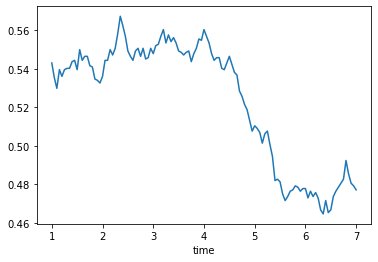

In [98]:
df_all[df_all['tasks']=='[3, 7, 11]'].groupby('time').mean()['acc'].plot()

<AxesSubplot:xlabel='time'>

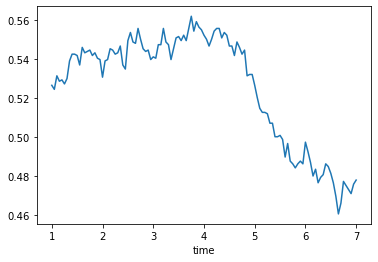

In [100]:
df_all[df_all['tasks']=='[4, 8, 12]'].groupby('time').mean()['acc'].plot()

<AxesSubplot:xlabel='time'>

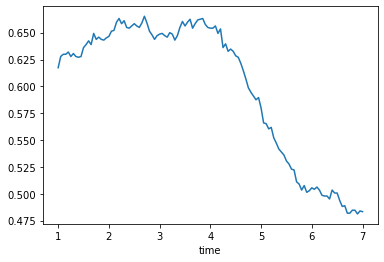

In [102]:
df_all[df_all['tasks']=='[5, 9, 13]'].groupby('time').mean()['acc'].plot()

<AxesSubplot:xlabel='time'>

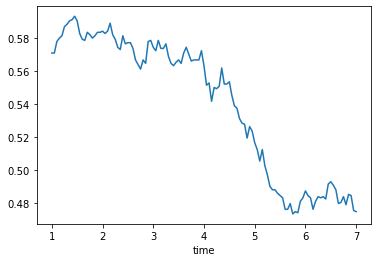

In [101]:
df_all[df_all['tasks']=='[6, 10, 14]'].groupby('time').mean()['acc'].plot()

In [67]:
df_window=df_all[['window','acc']]
df_window.groupby(['window']).mean()

,acc
window,
2,0.547086


In [68]:
df_window=df_all[['tasks','acc']]
df_window.groupby(['tasks']).mean()

,acc
tasks,
"[3, 7, 11]",0.523611
"[4, 8, 12]",0.525798
"[5, 9, 13]",0.598755
"[6, 10, 14]",0.540180


In [69]:
df_all[['acc','validation_i','tasks']].groupby(['validation_i','tasks']).mean()

acc
validation_i tasks                
0            [3, 7, 11]   0.516804
             [4, 8, 12]   0.544307
             [5, 9, 13]   0.582002
             [6, 10, 14]  0.559757
1            [3, 7, 11]   0.532576
             [4, 8, 12]   0.511134
             [5, 9, 13]   0.600872
             [6, 10, 14]  0.530234
2            [3, 7, 11]   0.535331
             [4, 8, 12]   0.515886
             [5, 9, 13]   0.594238
             [6, 10, 14]  0.533907
3            [3, 7, 11]   0.509734
             [4, 8, 12]   0.531864
             [5, 9, 13]   0.617906
             [6, 10, 14]  0.536823

In [70]:
df_window=df_all[['subject','tasks','acc']]
df_window.groupby(['subject','tasks']).mean()

acc
subject tasks                
1       [3, 7, 11]   0.490496
        [4, 8, 12]   0.503926
        [5, 9, 13]   0.686777
        [6, 10, 14]  0.568388
2       [3, 7, 11]   0.471074
...                       ...
37      [6, 10, 14]  0.519628
38      [3, 7, 11]   0.460950
        [4, 8, 12]   0.533264
        [5, 9, 13]   0.587810
        [6, 10, 14]  0.546488

[108 rows x 1 columns]

In [72]:
df_window=df_all[['subject','tasks','acc']]
df_window.groupby(['subject','tasks']).mean()

acc
subject tasks                
1       [3, 7, 11]   0.490496
        [4, 8, 12]   0.503926
        [5, 9, 13]   0.686777
        [6, 10, 14]  0.568388
2       [3, 7, 11]   0.471074
...                       ...
37      [6, 10, 14]  0.519628
38      [3, 7, 11]   0.460950
        [4, 8, 12]   0.533264
        [5, 9, 13]   0.587810
        [6, 10, 14]  0.546488

[108 rows x 1 columns]

In [75]:
df_window=df_all[['subject','acc']]
df_window.groupby(['subject']).mean()

,acc
subject,
1,0.562397
2,0.619731
3,0.533161
4,0.560950
5,0.569370
6,0.510331
7,0.566167
8,0.555527
9,0.480114


In [180]:
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin
w_times

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. ])

In [178]:
np.mean(scores_windows, 0)

array([0.48888889, 0.6       , 0.64444444, 0.7       , 0.74444444,
       0.8       , 0.86666667, 0.93333333, 0.95555556, 0.95555556,
       0.97777778, 0.95555556, 0.93333333, 0.92222222, 0.9       ,
       0.86666667])

ValueError: x and y must have same first dimension, but have shapes (31,) and (16,)

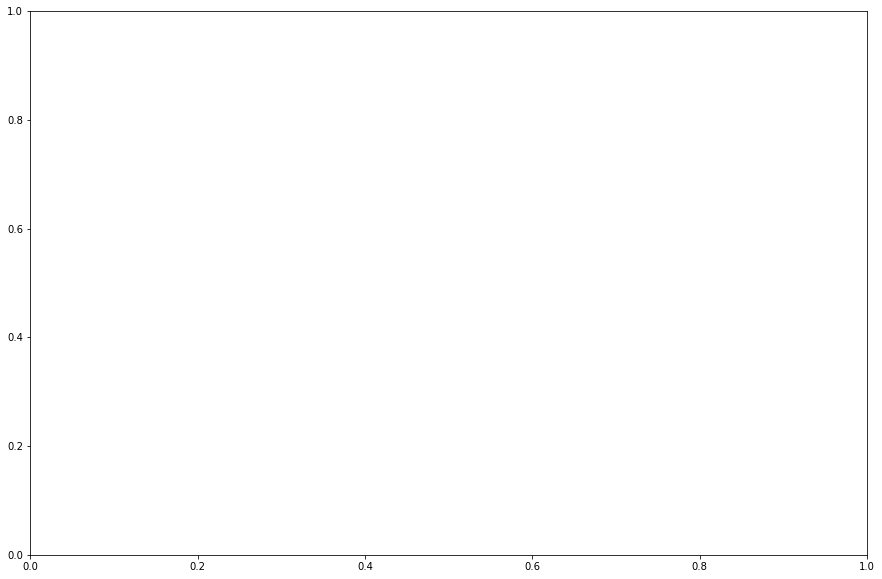

In [175]:
plt.figure(figsize=(15,10))

for i in range(1,20):
    
    scores_windows=np.load('CSP_results/CSP_results'+str(i)+'.npy')
    

    plt.plot(w_times, np.mean(scores_windows, 0), label=i)
    
    
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')

plt.show()

In [72]:
w_times

array([-0.5, -0.3, -0.1,  0.1,  0.3,  0.5,  0.7,  0.9,  1.1,  1.3,  1.5,
        1.7,  1.9,  2.1,  2.3,  2.5,  2.7,  2.9,  3.1,  3.3,  3.5,  3.7,
        3.9,  4.1,  4.3,  4.5,  4.7,  4.9,  5.1,  5.3,  5.5,  5.7,  5.9,
        6.1,  6.3,  6.5])

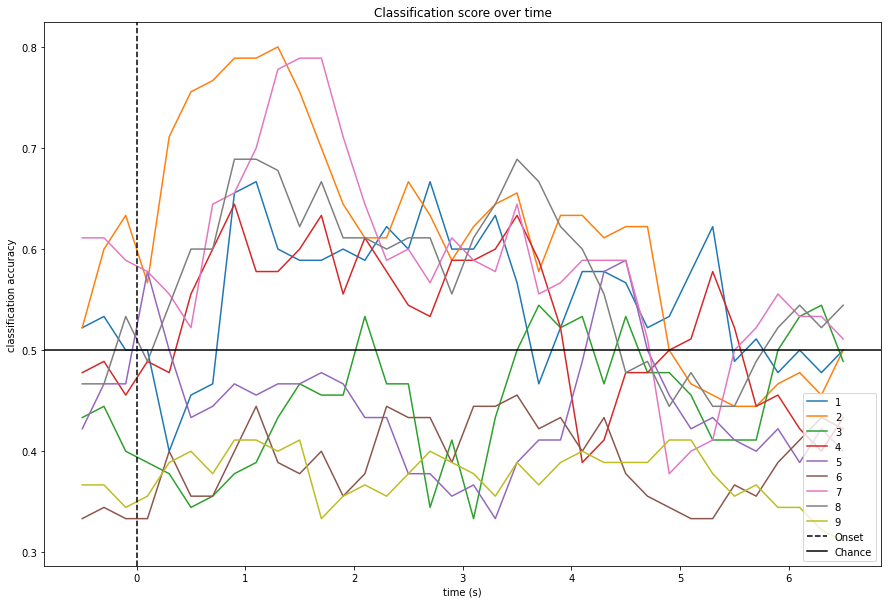

In [35]:
plt.figure(figsize=(15,10))
for i in range(1,10):
    
    scores_windows=np.load('Riemann_results/Riemann_results'+str(i)+'.npy')
    

    plt.plot(w_times,np.mean(scores_windows, 0), label=i)
    
    
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')

plt.show()

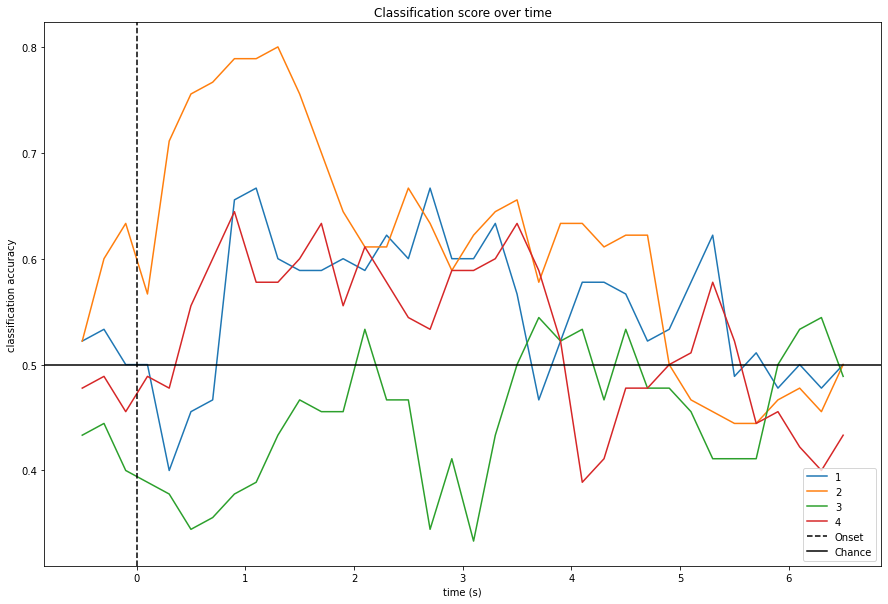

In [51]:
plt.figure(figsize=(15,10))
for i in range(1,5):
    
    scores_windows=np.load('Riemann_results/Riemann_results'+str(i)+'.npy')
    

    plt.plot(w_times,np.mean(scores_windows, 0), label=i)
    
    
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')

plt.show()

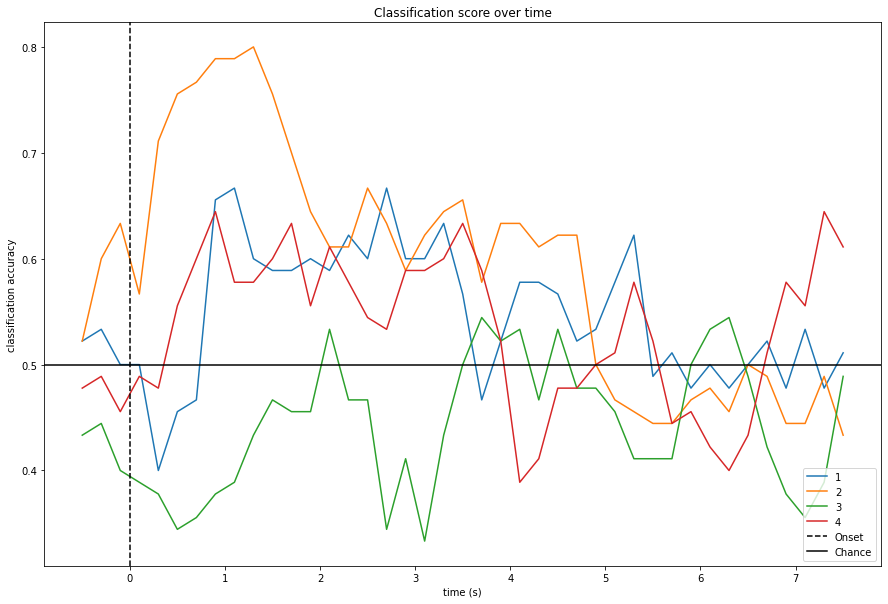

In [59]:
plt.figure(figsize=(15,10))
for i in range(1,5):
    
    scores_windows=np.load('Riemann_results/Riemann_results'+str(i)+'.npy')
    

    plt.plot(w_times,np.mean(scores_windows, 0), label=i)
    
    
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')

plt.show()